In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim

import random
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import json
from sklearn.metrics import auc, roc_curve, precision_recall_curve

In [ ]:
print(torch.__version__)

1.13.0


---
# 1. Dataset Module

In [ ]:
class UCF_Crime_Dataset(Dataset):
    def __init__(self, root="./feature_extracted/train/10-crop/", transform=None):
        self.data = []
        self.label = []
        self.anomaly_idx = []  #to store idex of abnormal video in self.data[]. to faster the random process
        self.normal_idx = []    #to store idex of normal video in self.data[]
        self.transform = transform

        #for root get path
        curr_idx = 0
        file_names = os.listdir(root) #eg. file_names = ['Robbery1.pt', 'Robbery2.pt']
        for file_name in file_names:
            path = os.path.join(root, file_name) # eg. "./feature_extracted/train/Robbery1.pt"
            self.data.append(path)
            if "Normal" in file_name: #Normal
                self.label.append(0)
                self.normal_idx.append(curr_idx)
            else:
                self.label.append(1)
                self.anomaly_idx.append(curr_idx)
            curr_idx += 1

        self.total_anomaly = len(self.anomaly_idx)
        self.total_normal = len(self.normal_idx)


    def __len__(self):
        return len(self.data)
        

    def __getitem__(self, idx):
        #when batch_size = 1, return 1 abnormal, 1 normal

        #if label[idx] is abnormal, randomly select a normal video
        if self.label[idx] == 1:
            random_idx = random.randint(0, self.total_normal-1)
            idx2 = self.normal_idx[random_idx]
        #else, randomly select a abnormal video
        else:
            random_idx = random.randint(0, self.total_anomaly-1)
            idx2 = self.anomaly_idx[random_idx]

        #let x1 alwasy be anomaly video, x2 be normal video
        if self.label[idx] == 1:
            anomaly_fea = torch.load(self.data[idx])
            normal_fea = torch.load(self.data[idx2])
        else:
            anomaly_fea = torch.load(self.data[idx2])
            normal_fea = torch.load(self.data[idx])

        if self.transform != None:
            anomaly_fea = self.transform(anomaly_fea)
            normal_fea = self.transform(normal_fea)

        return anomaly_fea, normal_fea

In [ ]:
trainset = UCF_Crime_Dataset(root="./feature_extracted/train/10-crop/") 
#trainset = UCF_Crime_Dataset(root="./feature_extracted/train_old_ori_1crop")
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0) #sultani used batch_size 30

In [ ]:
print(trainset.total_anomaly)
print(trainset.total_normal)

8100
8000


In [ ]:
for anomaly_fea, normal_fea in trainloader:
    #anomaly_fea = (b,c,nsegment)
    #normal_fea = (b,c,nsegment)
    print(anomaly_fea.shape)
    print(normal_fea.shape)
    x = anomaly_fea[:,:,1].clone().detach()
    print(x.shape)
    break

torch.Size([32, 1024, 32])
torch.Size([32, 1024, 32])
torch.Size([32, 1024])


---
# 2. Contrastive Head

In [ ]:
print(9/3)
print(9/3*2)

3.0
6.0


In [ ]:
class Contrastive_head(nn.Module):
    def __init__(self, num_center=2, in_channels=32, lambda_1=0.0001, beta=0.0001, m=1.25):
        super().__init__()
        
        self.num_class = 2
        self.num_center = num_center #number of center per class
        self.in_channels = in_channels
        self.lambda_1 = lambda_1
        self.beta = beta
        self.m = torch.tensor(m)
        self.Centers = nn.Parameter(torch.randn(2, num_center, self.in_channels), requires_grad=True) #(nclass,ncenter,c)

    def forward(self, x, device):
        #x = (b*3,c,k)
        #top 3 score from normal video
        #last 3 score from anomaly video
        #top 3 score from anomaly video
        
        # compute intra distance
        intra_distance = torch.mean(self.compute_intra_dist(x[:int(x.shape[0]/3)], self.Centers[0]) + \
                                    self.compute_intra_dist(x[int(x.shape[0]/3):int(x.shape[0]/3*2)], self.Centers[0]) + \
                                    self.compute_intra_dist(x[int(x.shape[0]/3*2):], self.Centers[1]))
        
        # compute inter distance
        inter_distance = self.compute_inter_dist(self.Centers[0], self.Centers[1], self.m, device) 

        # compute multicenter loss
        mc_loss = self.lambda_1 * intra_distance + self.beta * inter_distance

        return mc_loss

    def compute_intra_dist(self, x, centers):
        #x = (b,c,nsegment)
        centers2 = centers.repeat(x.shape[0], x.shape[2], 1, 1)
        #centers2 = (b, nsegment, ncenter, c)
        centers2 = centers2.permute(2,0,3,1)
        #centers2 = (ncenter,b,c,nsegment)
        dist_ctr_fea = (centers2 - x).square().sum(dim=2).sqrt()
        #dist_ctr_fea = (ncenter, b, nsegment)    
        min_dist_fea_ctr, idx = torch.min(dist_ctr_fea, dim=0)
        #min_dist_fea_ctr = (b, nsegment)
        sum_dist_fea_ctr = torch.mean(min_dist_fea_ctr, dim=1) #changed from sum to mean
        #sum_dist_fea_ctr = (b)
        return sum_dist_fea_ctr

    def compute_inter_dist(self, norm_centers, anom_centers, m, device):
        #norm_centers = (ncenter, c)
        #anom_centers = (ncenter, c)
        total_ctr = norm_centers.shape[0] + anom_centers.shape[0] # (ncenter+ncenter)
        centers = torch.cat((norm_centers, anom_centers), dim=0)
        #centers = (ncenter+ncenter, c)
        centers2 = centers.unsqueeze(0)
        #centers = (1, ncenter, c)
        dist = torch.cdist(centers2, centers2).squeeze()
        #dist = (total_ctr,total_ctr)
        margin = m.repeat(dist.shape[0], dist.shape[1]) #margin2 = (total_ctr,total_ctr)
        margin = margin.to(device)
        zeros = torch.zeros_like(dist) #zeros = (total_ctr,total_ctr)
        zeros = zeros.to(device)
        inter_dist = torch.max(zeros, margin-dist).sum() / (total_ctr*(total_ctr-1)) 
        return inter_dist

---
# 3. U-Net

In [ ]:
# Reference: https://amaarora.github.io/2020/09/13/unet.html

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        
        super().__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch        
        
        self.conv1 = nn.Conv1d (in_ch, out_ch, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=5, stride=1, padding=2)        
        self.conv3 = nn.Conv1d(out_ch, out_ch, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        r = x
        r = self.conv2(r)
        r = F.relu(r)
        r = self.conv3(r)
        x = x + r
        x = F.relu(x)
        return x
        
class Encoder(nn.Module):
    def __init__(self, in_channels, blk_channels):
        super().__init__()
        self.in_channels = in_channels
        self.blk_channels = blk_channels
        channels = [in_channels] + list(blk_channels)
        self.enc_blocks = nn.ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
    def forward(self, x):
        enc_out = []
        for i, block in enumerate(self.enc_blocks):
            x = block(x)
            enc_out.append(x)
            if i < len(self.enc_blocks)-1:
                x = F.max_pool1d(x, 2, 2)
        return enc_out
    
class Decoder(nn.Module):
    def __init__(self, blk_channels):
        super().__init__()
        self.channels = blk_channels[::-1]  # reverse the blk_channels
        self.upconvs = nn.ModuleList ([nn.ConvTranspose1d(self.channels[i], self.channels[i+1], kernel_size=2, stride=2) 
                                       for i in range(len(self.channels)-1)])
        self.dec_blocks = nn.ModuleList([Block(self.channels[i]*2, self.channels[i+1]) 
                                         for i in range(len(self.channels)-1)]) 
        
    def crop(self, enc_fea, x):
        _, _, L = x.shape
        _, _, Le = enc_fea.shape
        start = (Le - L)//2
        return enc_fea[:,:, start:start+L]
        
    def forward(self, enc_out, inputs):
        enc_out = enc_out[::-1]  # reverse the order
        x = enc_out[0]
        enc_out = enc_out[1:]
        for i in range(len(self.channels)-1):
            x1 = self.upconvs[i](x)
            x2 = self.crop(enc_out[i], x1)
            x = torch.cat([x1, x2], dim=1)
            x = self.dec_blocks[i](x)
        x = F.interpolate(x, inputs.shape[-1])
        return x
    
class Head(nn.Module):
    def __init__ (self, channels):
        super().__init__()
        self.layers = nn.ModuleList([nn.Conv1d(channels[i], channels[i+1], kernel_size=1) for i in range(len(channels)-1)])
        self.dropout = nn.Dropout(p=0.7) 
        
    def forward(self, x, isTraining):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == len(self.layers) - 1:
                x = torch.sigmoid(x)
            else:
                x = F.relu(x)
                if isTraining == True:
                    x = self.dropout(x)
                last_fea = x
        return last_fea, x
        
class Model(nn.Module):
    def __init__(self, in_channels=1024, 
                 blk_channels  = (1024, 1024, 1024, 1024),  
                 head_channels = (1024, 512, 32, 1)):
        super().__init__()
        self.in_channels  = in_channels
        self.blk_channels = blk_channels
        self.encoder = Encoder(in_channels, blk_channels)
        self.decoder = Decoder(blk_channels)
        self.head    = Head(head_channels)
        self.contrastive_head = Contrastive_head(num_center=16, in_channels=32, lambda_1=0.00256, beta=0.2304, m=1.25)

    def forward(self, inputs, isTraining=False, device="cpu"):
        #inputs = (b*2,c,nsegment):(?,1024,32)
        enc_output = self.encoder(inputs)               
        dec_output = self.decoder(enc_output, inputs)      
        last_fea, segment_scores = self.head(dec_output, isTraining)
        #last_fea = (b*2, 32, nsegment), features just before classification layer
        #segment_scores = (b*2, 1, nsegment)
        if isTraining == True:
            """#============= loss function =============="""
            bce, idx_topK_anom, idx_lastK_anom, idx_topK_norm = self.myLossFunction(segment_scores)
            #idx_topK_anom = (b,ksegment)

            """#============== get topk & lastk feature ===================="""
            last_fea = last_fea.to("cpu")
            last_fea = last_fea.permute(1,0,2) #convert (b*2, 32, nsegment) to (32, b*2, nsegment)
            normal_features = last_fea[:,:int(last_fea.shape[1]/2)] #segment feature in normal video 
            anomaly_features = last_fea[:,int(last_fea.shape[1]/2):] #segment feature in anomaly video 
            #normal_features = (32, b, nsegment)
            #anomaly_features = (32, b, nsegment)

            total_topk_norm_feature = torch.zeros(0)
            total_topk_abn_feature = torch.zeros(0)
            total_lastk_abn_feature = torch.zeros(0)
            #get topk features from normal video
            for normal_feature in normal_features: 
                topk_norm_feature = torch.gather(normal_feature, 1, idx_topK_norm)     
                #topk_norm_feature = (b,k)
                topk_norm_feature = torch.unsqueeze(topk_norm_feature, 0)
                #topk_norm_feature = (1,b,k)
                total_topk_norm_feature = torch.cat((total_topk_norm_feature, topk_norm_feature), dim=0)  

            #get topk and lastk features from anomaly video
            for abnormal_feature in anomaly_features: 
                topk_abn_feature = torch.gather(abnormal_feature, 1, idx_topK_anom)  
                lastk_abn_feature = torch.gather(abnormal_feature, 1, idx_lastK_anom)   
                #topk_abn_feature = (b,k)
                topk_abn_feature = torch.unsqueeze(topk_abn_feature, 0)
                lastk_abn_feature = torch.unsqueeze(lastk_abn_feature, 0)
                #topk_abn_feature = (1,b,k)
                total_topk_abn_feature = torch.cat((total_topk_abn_feature, topk_abn_feature), dim=0)  
                total_lastk_abn_feature = torch.cat((total_lastk_abn_feature, lastk_abn_feature), dim=0) 
            
            #total_topk_norm_feature = (c,b,k)
            #total_topk_abn_feature = (c,b,k)
            #total_lastk_abn_feature = (c,b,k)
            selected_feature = torch.cat((total_topk_norm_feature, total_lastk_abn_feature, total_topk_abn_feature), dim=1) #first half is lastK features, second half is topK features 
            selected_feature = selected_feature.permute(1,0,2) #convert (c,b*3,k) to (b*3,c,k)
            selected_feature = selected_feature.to(device)
            """#============== contrastive regularization =====================""" 
            mc_loss = self.contrastive_head(selected_feature, device)
            combination_loss = bce + mc_loss
            return combination_loss
        else:
            return last_fea, segment_scores 
            #last_fea = (b*2, c, nsegment)
            #segment_scores=(b*2, 1, nsegment)

    def myLossFunction(self, segment_scores, k=3, lambda_1=0.00008, lambda_2=0.00008):
        #convert (b,1,nsegment) to (b,nsegment)
        segment_scores = torch.squeeze(segment_scores, 1) 

        #to cpu
        segment_scores = segment_scores.to("cpu")

        #segment_scores = (b*2, nsegment)
        normal_scores = segment_scores[:int(segment_scores.shape[0]/2)]
        #normal_scores (b,nsegment)

        anomaly_scores = segment_scores[int(segment_scores.shape[0]/2):]
        #anomaly_scores (b,nsegment)
        #========== get top-k segment score ============
        topk_norm_scores, idx_topK_norm = torch.topk(normal_scores, k=k, dim=1, largest=True)   #top-k normal score (b,k)
        topk_anom_scores, idx_topK_anom = torch.topk(anomaly_scores, k=k, dim=1, largest=True) #top-k anomaly score (b,k)
        _, idx_lastK_anom = torch.topk(anomaly_scores, k=k, dim=1, largest=False) #last-k anomaly score (b,k)
        topk_scores = torch.cat((topk_norm_scores, topk_anom_scores), dim=0) #(b*2,k)

        #initialize label
        zeros = torch.zeros_like(topk_norm_scores) #(b,k)
        ones = torch.ones_like(topk_anom_scores) #(b,k)
        label = torch.cat((zeros, ones), dim=0) #(b*2,k)

        #=========== binary cross entropy loss ====================
        bce = F.binary_cross_entropy(topk_scores, label)  

        anomaly_scores = anomaly_scores.permute(1,0) #(nsegment,b)
        normal_scores = normal_scores.permute(1,0) #(nsegment,b)
        
        #========= get temporal smoothness ==========
        diff_neighbour = torch.randn(anomaly_scores.shape[0]-1, anomaly_scores.shape[1]) # (nsegment-1, b) difference of 2 neighbour segment
        for i in range(anomaly_scores.shape[0]-1): # #segments-1
            diff_neighbour[i] = torch.pow((anomaly_scores[i] - anomaly_scores[i+1]), 2) 

        temp_smoothness = lambda_1 * torch.sum(diff_neighbour, dim=0, keepdim=True) 

        #========= get sparsity ==========
        sparsity = lambda_2 * torch.sum(anomaly_scores, dim=0, keepdim=True) #(1, b)

        #final cost 
        cost = bce + torch.mean(temp_smoothness) + torch.mean(sparsity) 

        return cost, idx_topK_anom, idx_lastK_anom, idx_topK_norm

In [ ]:
import torch
x = torch.randn(2,3,4)
y = torch.randn(2,3,4)
z = torch.randn(2,3,4)
output = torch.cat((x,y,z), dim=1)
print(output.shape)

torch.Size([2, 9, 4])


In [ ]:
model = Model()

In [ ]:
#test case
for anomaly_fea, normal_fea in trainloader:
    features = torch.cat((normal_fea, anomaly_fea), dim=0)
    loss = model(features, isTraining=True)
    last_fea, segments_score = model(features)
    break
print(segments_score.shape)

torch.Size([64, 1, 32])


----
# 3. Loss Function

----
# 4. Train

In [ ]:
def evaluate(model, test_dir, annotation_txt):
    with open('./groundtruths.json', 'rb') as fp:
        groundtruths = json.load(fp)

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model = model.to(device)
    model.eval()

    pred_scores = torch.zeros(69589) #used to store the clip-level score for every test videos. 69589 clips, 1113424 frames
    idx = 0
    #=============== load feature according to the order in annotation file ================
    f = open(annotation_txt, "r")
    for line in f: 
        #eg. line = Abuse028_x264.mp4  Abuse  165  240  -1  -1  
        annotation = line.split(" ") #eg. annotation = ['Abuse028_x264.mp4', '', 'Abuse', '', '165', '', '240', '', '-1', '', '-1', '', '\n']
        video_name = annotation[0][:-4] #Abuse028_x264

        #============ combine version0~9 into 1 tensor =====================
        for i in range(10):
            path = os.path.join(test_dir, video_name+"_version"+str(i)+".pt")

            #================== load feature =====================
            x = torch.load(path, map_location=device) 
            #x = (c,nclip):(1024,?) 
            if i == 0:
                fea_clip = torch.randn((10,1024, x.shape[1]), device=device)
                #fea_clip = (ncrop,c,nclip):(10,1024,?)
            fea_clip[i] = x

        #fea_clip = (ncrop,c,nclip):(10,1024,?)
        with torch.no_grad():
            _, scores = model(fea_clip)
            #score = (ncrop,1,nclip)
        scores = scores.to("cpu")
        scores = torch.squeeze(scores)
        #score = (ncrop,nclip)
        #================= mean ======================
        scores = torch.mean(scores, dim=0)
        #scores = (nclip,)

        #store predicted clip-level scores for current video
        pred_scores[idx:idx+scores.shape[0]] = scores[:] #pred_scores = torch.cat((pred_scores, scores))
        idx += scores.shape[0]
    f.close()
    if idx != pred_scores.shape[0]:
        raise Exception(f"idx != pred_scores, idx={idx}, pred score={pred_scores.shape[0]}")
    #expand the clip-level scores to frame-level scores for all video
    pred_scores = np.repeat(np.array(pred_scores), 16) #should have 1113424
    return pred_scores

In [ ]:
def roc_auc(pred, gt_json="./groundtruths.json", showGraph=False):
    with open(gt_json, 'rb') as fp:
        gt = json.load(fp)
    fpr, tpr, threshold = roc_curve(list(gt), pred)
    myAUC = auc(fpr, tpr)

    if showGraph == True:
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    return myAUC

In [ ]:
def train(model, trainloader, epochs, model_name):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    model = model.to(device)
    
    loss_history = []
    auc_history = []
    highest_auc = 0.0
    save_dir = os.path.join("./saved_model", str(model_name))
    for e in range(epochs): # epoch iteration
        model.train() # set model to training mode
        print(f"Epochs [{e+1}/{epochs}]: ", end="")
        running_loss = []
        for anomaly_fea, normal_fea in trainloader: #batch iteration 
            features = torch.cat((normal_fea, anomaly_fea), dim=0)
            # features = (b*2, c, nsegment)

            #pass to device available
            features = features.to(device)

            # Clear all the gradient to 0
            optimizer.zero_grad()

            #forward propagation
            loss = model(features, isTraining=True, device=device)

            #compute loss 
            #loss = myLoss(segment_scores) + mc_loss

            #backpropagation
            loss.backward()

            # update the parameters
            optimizer.step()

            #store running(batch) loss
            running_loss.append(loss.item())

        #compute mean loss for current epoch
        train_loss = np.mean(running_loss)
        print(f'train loss = {train_loss:.4f},', end=' ')
        
        #store mean loss within each epoch
        loss_history.append(train_loss)

        #evaluate for every epoch
        if (e+1)%1 == 0:
            pred_scores = evaluate(model, test_dir="./feature_extracted/test/10-crop/", annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt")
            running_auc = roc_auc(pred=pred_scores, gt_json="./groundtruths.json")
            auc_history.append(running_auc)
            print(f'auc = {running_auc:.4f}')
            
            if running_auc > highest_auc:
                if os.path.exists(save_dir) == False: 
                    os.mkdir(save_dir)
                torch.save(model.state_dict(), os.path.join(save_dir,"highestAUC.pt"))
                highest_auc = running_auc
                
    torch.save(model.state_dict(), os.path.join(save_dir,"last.pt"))
    return loss_history, auc_history


In [ ]:
myModel = Model()
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0) 
optimizer = optim.Adam(myModel.parameters(), lr=0.0001, weight_decay=0.01) 
loss_history, auc_history = train(myModel, trainloader, epochs=500, model_name="top3pos_last3pos_top3neg_16centers_L0.00256_m1.25_b0.2304_1024c_B64")

Epochs [1/500]: train loss = 0.5128, auc = 0.7945
Epochs [2/500]: train loss = 0.3927, auc = 0.8033
Epochs [3/500]: train loss = 0.3525, auc = 0.8007
Epochs [4/500]: train loss = 0.2927, auc = 0.8084
Epochs [5/500]: train loss = 0.2549, auc = 0.8146
Epochs [6/500]: train loss = 0.2104, auc = 0.8183
Epochs [7/500]: train loss = 0.1788, auc = 0.8297
Epochs [8/500]: train loss = 0.1627, auc = 0.8126
Epochs [9/500]: train loss = 0.1365, auc = 0.8137
Epochs [10/500]: train loss = 0.1355, auc = 0.8304
Epochs [11/500]: train loss = 0.1264, auc = 0.8262
Epochs [12/500]: train loss = 0.1273, auc = 0.8314
Epochs [13/500]: train loss = 0.1058, auc = 0.8217
Epochs [14/500]: train loss = 0.1432, auc = 0.8347
Epochs [15/500]: train loss = 0.1159, auc = 0.8403
Epochs [16/500]: train loss = 0.1163, auc = 0.8306
Epochs [17/500]: train loss = 0.0950, auc = 0.8359
Epochs [18/500]: train loss = 0.0929, auc = 0.8388
Epochs [19/500]: train loss = 0.1243, auc = 0.8134
Epochs [20/500]: train loss = 0.0989, au

Epochs [160/500]: train loss = 0.0618, auc = 0.8310
Epochs [161/500]: train loss = 0.0586, auc = 0.8345
Epochs [162/500]: train loss = 0.0593, auc = 0.8340
Epochs [163/500]: train loss = 0.0931, auc = 0.8394
Epochs [164/500]: train loss = 0.0592, auc = 0.8388
Epochs [165/500]: train loss = 0.0587, auc = 0.8389
Epochs [166/500]: train loss = 0.0585, auc = 0.8320
Epochs [167/500]: train loss = 0.0588, auc = 0.8352
Epochs [168/500]: train loss = 0.0982, auc = 0.8294
Epochs [169/500]: train loss = 0.0677, auc = 0.8340
Epochs [170/500]: train loss = 0.0591, auc = 0.8348
Epochs [171/500]: train loss = 0.0587, auc = 0.8383
Epochs [172/500]: train loss = 0.0590, auc = 0.8367
Epochs [173/500]: train loss = 0.0590, auc = 0.8394
Epochs [174/500]: train loss = 0.0831, auc = 0.8348
Epochs [175/500]: train loss = 0.0599, auc = 0.8196
Epochs [176/500]: train loss = 0.0730, auc = 0.8321
Epochs [177/500]: train loss = 0.0651, auc = 0.8343
Epochs [178/500]: train loss = 0.0605, auc = 0.8370
Epochs [179/

Epochs [317/500]: train loss = 0.0736, auc = 0.8395
Epochs [318/500]: train loss = 0.0615, auc = 0.8435
Epochs [319/500]: train loss = 0.0581, auc = 0.8480
Epochs [320/500]: train loss = 0.0684, auc = 0.8442
Epochs [321/500]: train loss = 0.0589, auc = 0.8378
Epochs [322/500]: train loss = 0.0578, auc = 0.8450
Epochs [323/500]: train loss = 0.0619, auc = 0.8453
Epochs [324/500]: train loss = 0.0763, auc = 0.8386
Epochs [325/500]: train loss = 0.0580, auc = 0.8453
Epochs [326/500]: train loss = 0.0592, auc = 0.8382
Epochs [327/500]: train loss = 0.0652, auc = 0.8375
Epochs [328/500]: train loss = 0.0666, auc = 0.8436
Epochs [329/500]: train loss = 0.0679, auc = 0.8409
Epochs [330/500]: train loss = 0.0597, auc = 0.8372
Epochs [331/500]: train loss = 0.0591, auc = 0.8400
Epochs [332/500]: train loss = 0.0578, auc = 0.8355
Epochs [333/500]: train loss = 0.0716, auc = 0.8413
Epochs [334/500]: train loss = 0.0579, auc = 0.8385
Epochs [335/500]: train loss = 0.0715, auc = 0.8376
Epochs [336/

Epochs [474/500]: train loss = 0.0676, auc = 0.8434
Epochs [475/500]: train loss = 0.0576, auc = 0.8448
Epochs [476/500]: train loss = 0.0577, auc = 0.8444
Epochs [477/500]: train loss = 0.0572, auc = 0.8404
Epochs [478/500]: train loss = 0.0733, auc = 0.8413
Epochs [479/500]: train loss = 0.0584, auc = 0.8406
Epochs [480/500]: train loss = 0.0576, auc = 0.8459
Epochs [481/500]: train loss = 0.0587, auc = 0.8375
Epochs [482/500]: train loss = 0.0874, auc = 0.8448
Epochs [483/500]: train loss = 0.0583, auc = 0.8431
Epochs [484/500]: train loss = 0.0569, auc = 0.8408
Epochs [485/500]: train loss = 0.0571, auc = 0.8432
Epochs [486/500]: train loss = 0.0761, auc = 0.8444
Epochs [487/500]: train loss = 0.0591, auc = 0.8434
Epochs [488/500]: train loss = 0.0570, auc = 0.8441
Epochs [489/500]: train loss = 0.0572, auc = 0.8456
Epochs [490/500]: train loss = 0.0781, auc = 0.8424
Epochs [491/500]: train loss = 0.0614, auc = 0.8437
Epochs [492/500]: train loss = 0.0568, auc = 0.8432
Epochs [493/

In [ ]:
def plot(loss_history, auc_history):
    """plot graph Loss VS Epoch"""
    x = [(i+1) for i in range(len(loss_history))]
    plt.plot(x, loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    """plot graph AUC VS Epoch"""
    print("Highest AUC:", max(auc_history))
    x = [(i+1) for i in range(len(auc_history))]
    plt.plot(x, auc_history)
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    #plt.ylim([0, 1])
    plt.show()

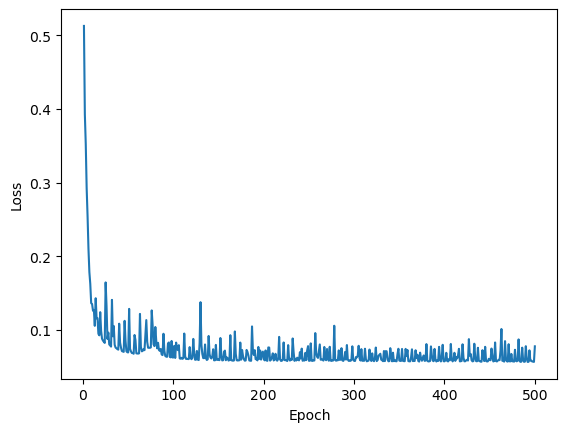

Highest AUC: 0.8523867669851846


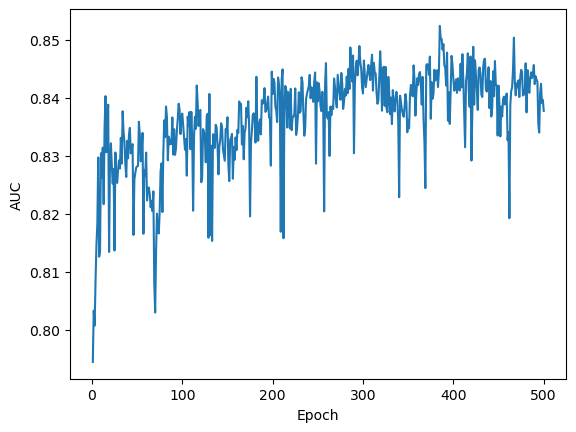

In [ ]:
plot(loss_history, auc_history)